# Prophet Base template

> In this notebook we will use **prophet** package to forecast hourly energy use.<br>
> В этом ноутбуке будет разобраны оснонвые работы при работе с временными рядами

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
from datetime import datetime
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
plt.style.use("dark_background")
DATASETS = Path().cwd() / 'data'

## LOAD DATA

The data we will be using is hourly power consumption data from PJM.<br>
Energy consumtion has some unique charachteristics. <hr>
В качестве данных мы будем использовать почасовые данные о потреблении электроэнергии от PJM.
<br>Потребление электроэнергии имеет ряд уникальных характеристик. 

In [25]:
df_ts = pd.read_csv(f"{DATASETS}/PJME_hourly.csv.zip", index_col=[0], parse_dates=[0])
df_ts.columns = ['electricity_consumption']
df_ts.info()
df_ts.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   electricity_consumption  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


,electricity_consumption
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


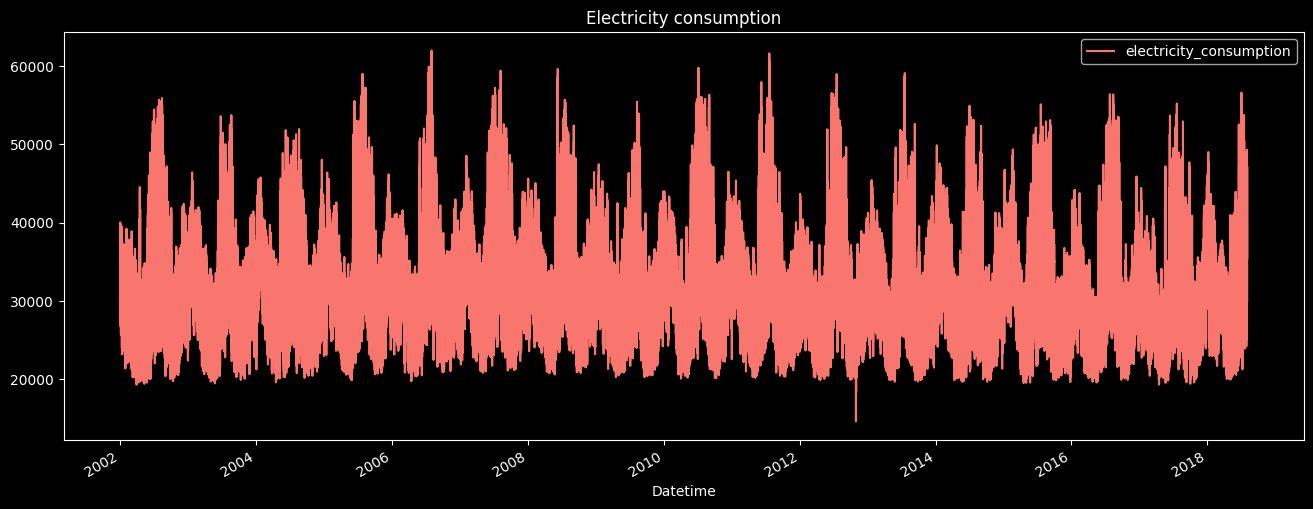

In [26]:
# Plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
df_ts.plot(style='-', figsize=(16,6), color=color_pal[0], title='Electricity consumption')
plt.show();

## EDA

> We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.<hr>
> Мы создадим некоторые функции временных рядов, чтобы увидеть, как на тенденции влияют день недели, час, время года и т.д.

In [27]:
def create_features(df: pd.DataFrame, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_ts, label='electricity_consumption')
features_and_target = pd.concat([X, y], axis=1)

In [28]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,electricity_consumption
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends

* Power demand has strong daily and seasonal properties.
* Day of week also seems to show differences in peaks

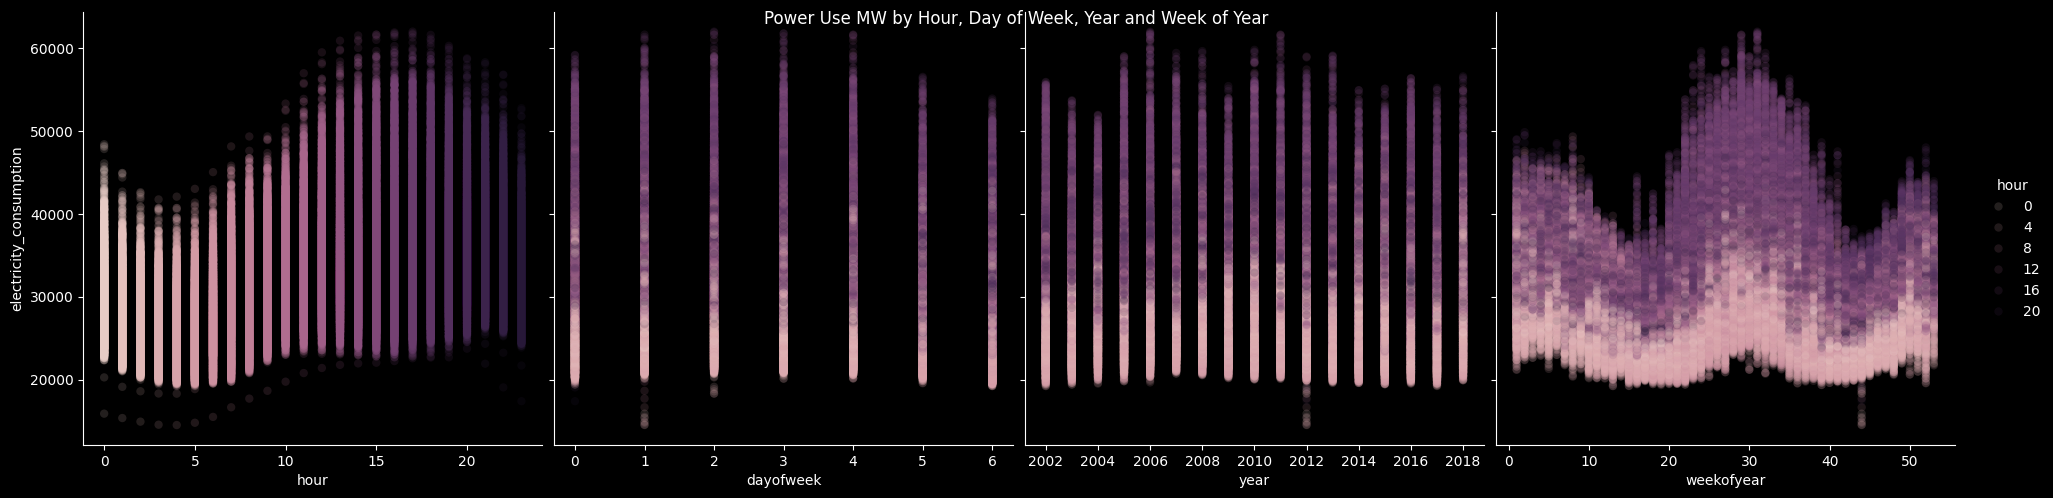

In [29]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='electricity_consumption',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show();

## Train/Test Split

In [30]:
SPLIT_DATE = '01-Jan-2015'
train = df_ts.loc[df_ts.index <= SPLIT_DATE].copy()
test = df_ts.loc[df_ts.index > SPLIT_DATE].copy()

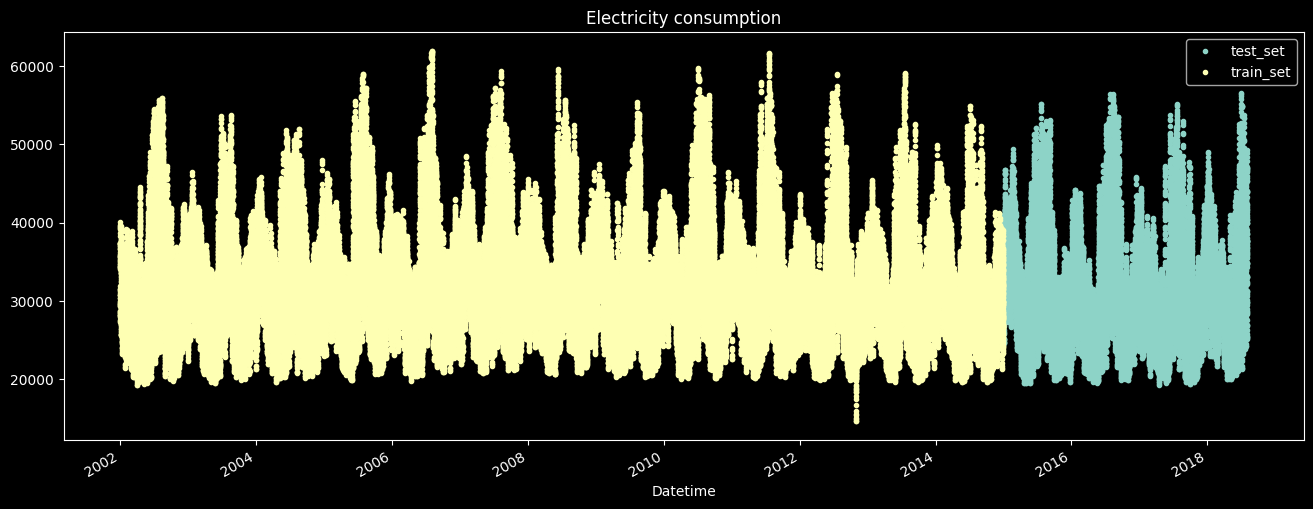

In [31]:
test\
.rename(columns={'electricity_consumption': 'test_set'})\
.join(train.rename(columns={'electricity_consumption': 'train_set'}),
          how='outer') \
.plot(figsize=(16,6), title='Electricity consumption', style='.')
plt.show()

## Simple Prophet Model

* Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
* Модель Prophet ожидает, что набор данных будет назван определенным образом. Мы переименуем столбцы нашего датафрейма перед тем, как передать его в модель.

In [32]:
# Format data for prophet model using ds and y
train = train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'electricity_consumption':'y'})
train.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [33]:
test = test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'electricity_consumption':'y'})
test.head()

,ds,y
0,2015-12-31 01:00:00,24305.0
1,2015-12-31 02:00:00,23156.0
2,2015-12-31 03:00:00,22514.0
3,2015-12-31 04:00:00,22330.0
4,2015-12-31 05:00:00,22773.0


In [34]:
%%time
# Setup and train model and fit
model = Prophet()
model.fit(train)

15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:51 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 4.88 s, sys: 144 ms, total: 5.03 s
Wall time: 47 s


In [35]:
%%time
# Predict on training set with model
test_fcst = model.predict(df=test)

CPU times: user 3.68 s, sys: 2.12 s, total: 5.8 s
Wall time: 3.82 s


In [36]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23992.353471,32884.791224,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22284.288173,31150.107552,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21584.359280,30356.586773,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21488.009965,30511.618316,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21714.478162,30872.322302,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


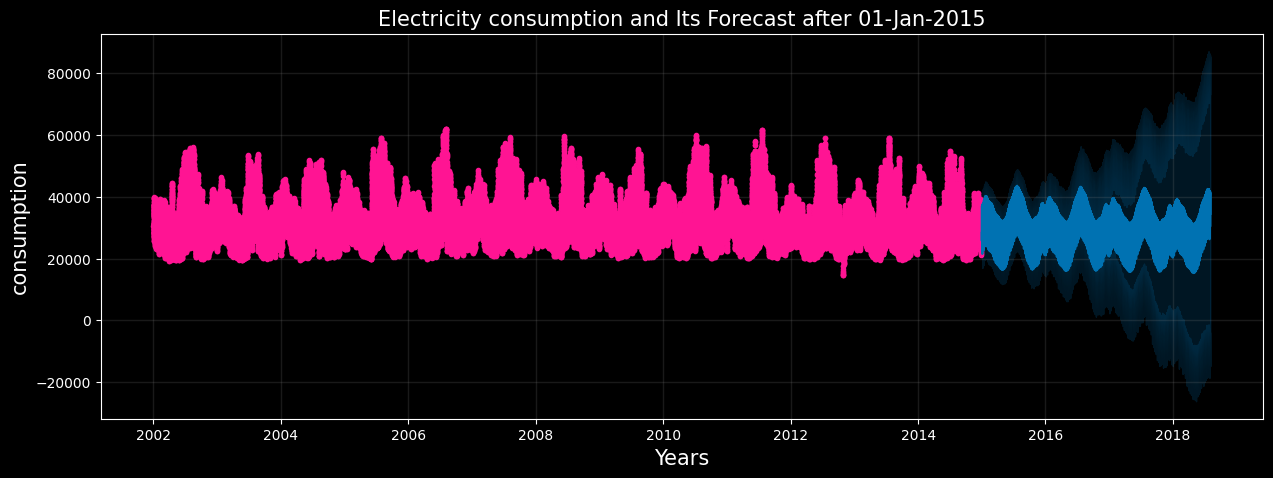

In [37]:
# plt.style.use('fivethirtyeight') # For plots
# Plot the forecast
fig, ax = plt.subplots(1)

fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(test_fcst, ax=ax,)

plt.gca().get_lines()[0].set_color("deeppink")
plt.title(f"Electricity consumption and Its Forecast after {SPLIT_DATE}", size=15)
plt.xlabel("Years", size=15)
plt.ylabel("consumption", size=15)
plt.show()
plt.show();

## Compare Forecast to Actuals

In [38]:
test = test.set_index(['ds'])

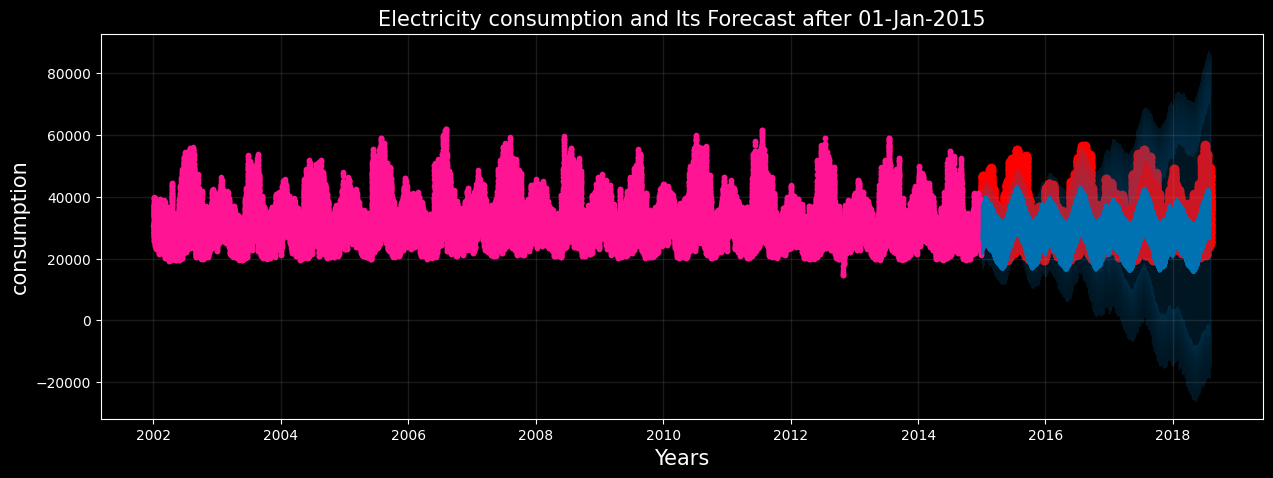

In [39]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
ax.scatter(test.index, test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)
plt.gca().get_lines()[0].set_color("deeppink")
plt.title(f"Electricity consumption and Its Forecast after {SPLIT_DATE}", size=15)
plt.xlabel("Years", size=15)
plt.ylabel("consumption", size=15)
plt.show()
plt.show();

## Look at first day of predictions

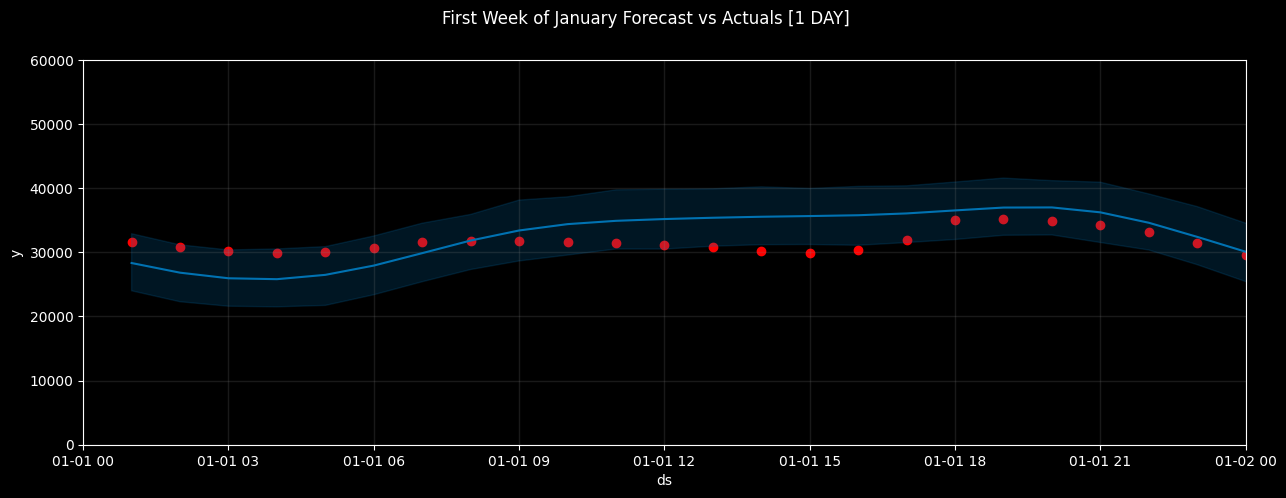

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

lower_d = datetime.strptime('01-01-2015', '%d-%m-%Y')
upper_d = datetime.strptime('02-01-2015', '%d-%m-%Y')

ax.set_xbound(lower=lower_d,
              upper=upper_d)

ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals [1 DAY]')

## Single Week of Predictions

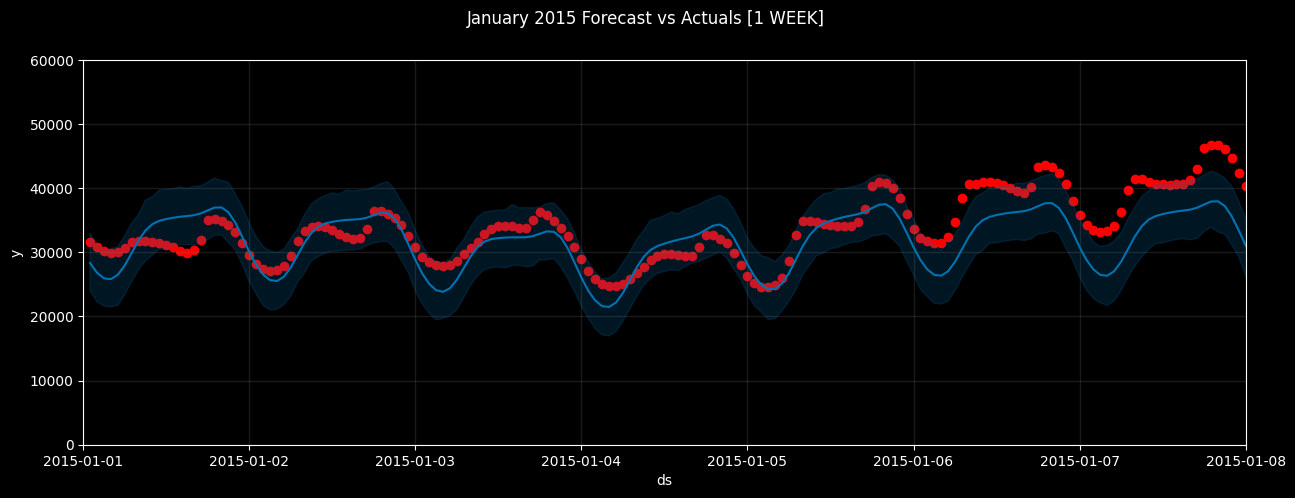

In [41]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
ax.scatter(test.index, test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

lower_d = datetime.strptime('01-01-2015', '%d-%m-%Y')
upper_d = datetime.strptime('08-01-2015', '%d-%m-%Y')

ax.set_xbound(lower=lower_d,
              upper=upper_d)

ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals [1 WEEK]')

## Look at first month of predictions

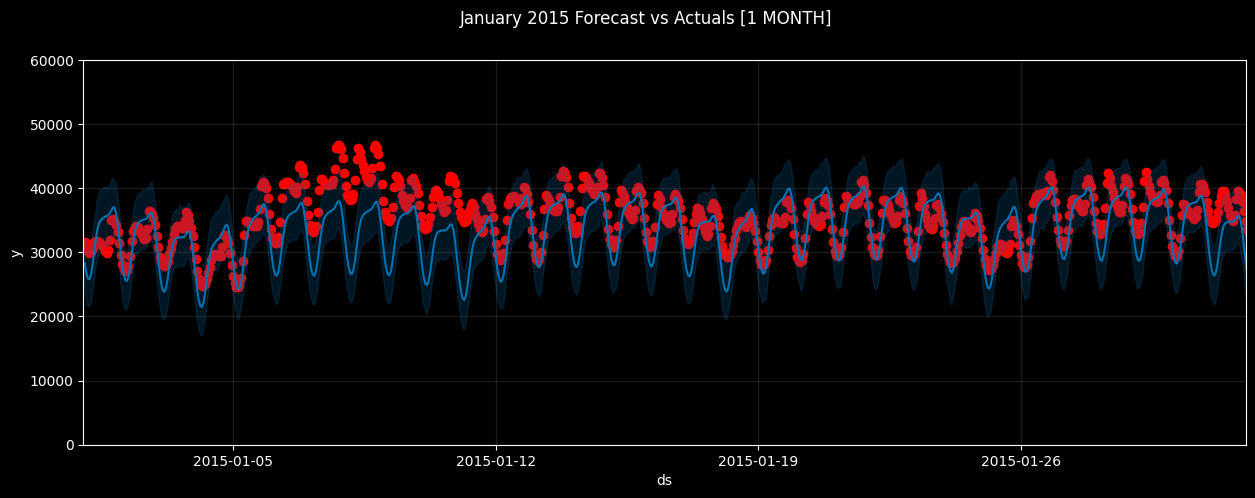

In [42]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

lower_d = datetime.strptime('01-01-2015', '%d-%m-%Y')
upper_d = datetime.strptime('01-02-2015', '%d-%m-%Y')

ax.set_xbound(lower=lower_d,
              upper=upper_d)
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals [1 MONTH]')

## Error Metrics

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
print(f"RMSE error is: {mean_squared_error(y_true=test['y'], y_pred=test_fcst['yhat'])}\n"
      f"MAE error is: {mean_absolute_error(y_true=test['y'], y_pred=test_fcst['yhat'])}\n"
      f"MAPE error is: {mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fcst['yhat'])}")

RMSE error is: 43784240.02744754
MAE error is: 5181.911537928106
MAPE error is: 16.512003880182647


<hr>

In future we can evaluate some Regressor algo to predict more correct!